# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/電腦視覺/圖片')

Mounted at /content/gdrive


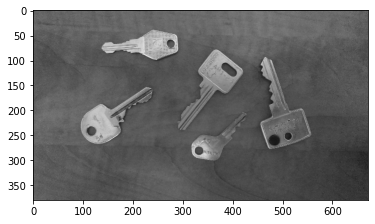

image.shape:  (380, 672, 3)


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("keys.png")
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)


## Step 1. Gaussian filter

In [ ]:
def padding_img(img,k_size,style='edge'):
  # ------------ To do ------------- #
  p_size=k_size//2
  shape=list(img.shape)
  shape[0]=p_size*2+shape[0]
  shape[1]=p_size*2+shape[1]
  if p_size != 0:
    imagePadded = np.zeros(shape, dtype=np.int32)
    imagePadded[int(p_size):int(-1 * p_size), int(p_size):int(-1 * p_size)] = img
    return imagePadded
  else:
    imagePadded = img
    return imagePadded

def gaussian_kernel(size):
  # ------------ To do ------------- #
  sigma = 0.3*((size-1)*0.5 - 1) + 0.8
  low=0-size//2
  hight=0+size//2
  Gaussian=[]
  #各係數相加後總值
  total=0
  for i in range(low,hight+1):
    Filter_list = []
    for j in range(low,hight+1): 
        #高斯函數公式
        # -------------- To do ----------------- #
        value=1/(2*math.pi*sigma**2)*math.e**-((i**2+j**2)/(2*sigma**2))
        Filter_list.append(value)
        total+=value
    Gaussian+= [Filter_list]
  return np.array(Gaussian)/total

def Gaussian_Filter(KernelSize,image):
    col,row,channels =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((col,row,channels))
    padimg = padding_img(image,KernelSize,style='reflect')

    # ------------ To do ------------- #
    kernel_h=KernelSize
    kernel_w=KernelSize
    for i in range(col):
      for j in range(row):
        sum=0
        for m in range(kernel_h):
          for n in range(kernel_w):
            sum=sum+Gaussian_Kernel[m][n]*padimg[i+m][j+n]
        resx[i][j]=sum
    return np.clip(resx,0,255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


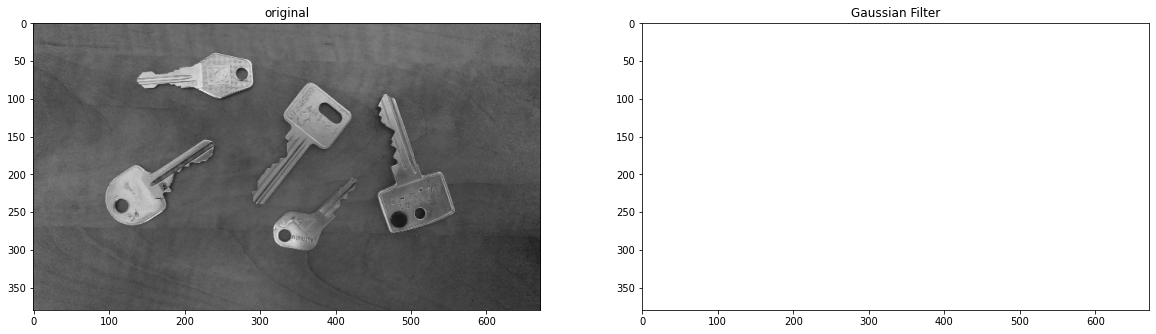

In [ ]:
KernelSize = 3
gaussianImg = Gaussian_Filter(KernelSize,img_org)
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img_org)

plt.subplot(1,2,2)
plt.title("Gaussian Filter")
plt.imshow(gaussianImg)

plt.show()

## Step 2. Find magnitude and orientation of gradient
![](https://i.imgur.com/G4e6Z4n.png)*斜體文字*

In [ ]:
# https://blog.csdn.net/weixin_52668444/article/details/117372347
# 該算子包含兩組3x3的矩陣，分別為橫向及縱向，將之與圖像作平面卷積，即可分別得出橫向及縱向的亮度差分近似值。分別代表經橫向及縱向邊緣檢測的圖像

def sobel(img, filtering_type="horizontal"):
    h, w, channels = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
    Gx = np.zeros((h - 2, w - 2))
    Gy = np.zeros((h - 2, w - 2))

    # ------------ To do ------------- #
    img = np.float32(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    for i in range(h-2):
      for j in range(w-2):
        horizontalSum=0
        verticalSum=0
        for m in range(3):
          for n in range(3):
            horizontalSum=horizontalSum+(horizontal[m][n]*img[i+m][j+n])
            verticalSum=verticalSum+(vertical[m][n]*img[i+m][j+n])
        Gx[i][j]=horizontalSum
        Gy[i][j]=verticalSum
    
    if filtering_type=="horizontal":
      return np.clip(Gx,0,255)
    elif filtering_type=="vertical":
      return np.clip(Gy,0,255)
    else:
      direction=np.arctan(Gy/Gx)
      amplitude = np.sqrt(np.square(Gx)+np.square(Gy))
      amplitude = np.clip(amplitude,0,255).astype('int32')
      Gx=np.clip(Gx,0,255)
      Gy=np.clip(Gy,0,255)
      return amplitude,direction,Gx,Gy

def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


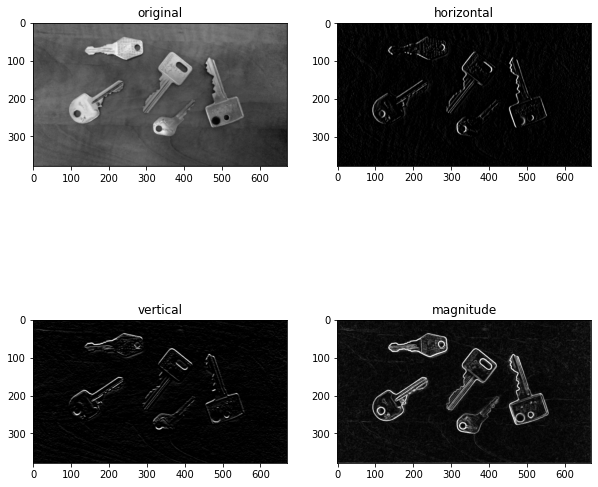

In [ ]:
# ------------ To do ------------- #
# print("gaussian shape:",gaussianImg.shape)
gray = np.float32(gaussianImg)
gray = cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
amplitude,direction,Gx,Gy = sobel(gaussianImg,"magnitude")

fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("original")
plt.imshow(gray, cmap='gray')

plt.subplot(2,2,2)
plt.title("horizontal")
plt.imshow(Gx, cmap='gray')

plt.subplot(2,2,3)
plt.title("vertical")
plt.imshow(Gy, cmap='gray')

plt.subplot(2,2,4)
plt.title("magnitude")
plt.imshow(amplitude, cmap='gray')


plt.show()

## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [ ]:
# 清楚的:https://www.youtube.com/watch?v=PtSgA19sC5g
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            # ------------ To do ------------- #
            # 0 deg
            if(gradient[j][i]<gradient[j][i+1] or gradient[j][i]<gradient[j][i-1]):
              gradient_copy[j][i]=0
            #  # 45 deg
            if(gradient[j][i]<gradient[j+1][i+1] or gradient[j][i]<gradient[j-1][i-1]):
              gradient_copy[j][i]=0
            #  # 90 deg
            if(gradient[j][i]<gradient[j+1][i] or gradient[j][i]<gradient[j-1][i]):
              gradient_copy[j][i]=0
            #  # 135 deg
            if(gradient[j][i]<gradient[j-1][i+1] or gradient[j][i]<gradient[j+1][i-1]):
              gradient_copy[j][i]=0
      
    return gradient_copy

# amplitude,direction,Gx,Gy = sobel(img,"magnitude")
After_non_maximum_supression = non_maximum_suppression(amplitude,direction)


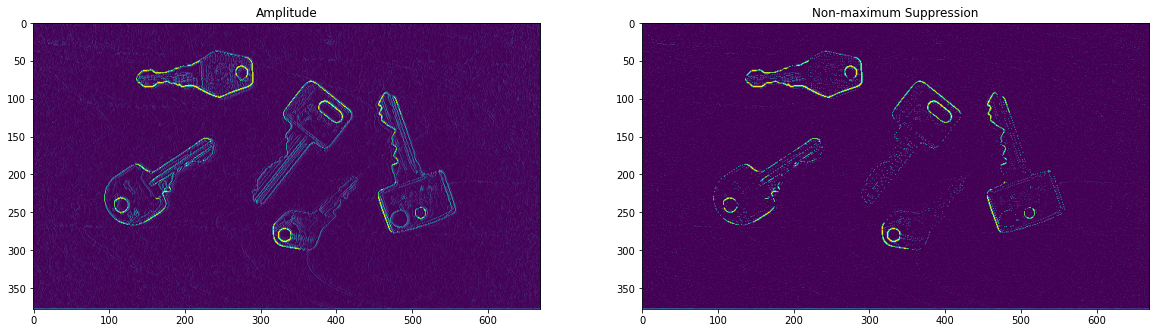

In [ ]:
# ------------ To do ------------- #
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Amplitude")
plt.imshow(amplitude)

plt.subplot(1,2,2)
plt.title("Non-maximum Suppression")
plt.imshow(After_non_maximum_supression)

plt.show()

## Step 4. Thresholding edges

In [ ]:
print(range(-1,2))
for i in range(-1,2):
  print(i)

range(-1, 2)
-1
0
1


In [ ]:
def seperate(img, minimum = 60, maximum = 180):
    # ------------ To do ------------- #
    newImg = img.copy()
    height,width= img.shape
    for j in range(1, height-1):
      for i in range(1, width-1):
        if(img[j][i]<minimum):
          newImg[j][i]=0
        elif(img[j][i]<maximum and img[j][i]>minimum):
          isEdge=False
          for dj in range(-1,2):
            for di in range(-1,2):
              if(img[j+dj][i+di]>maximum):
                isEdge=True
          if(isEdge==False):
            newImg[j][i]=0
    return newImg
thresholding = seperate(After_non_maximum_supression, minimum = 15, maximum = 90)

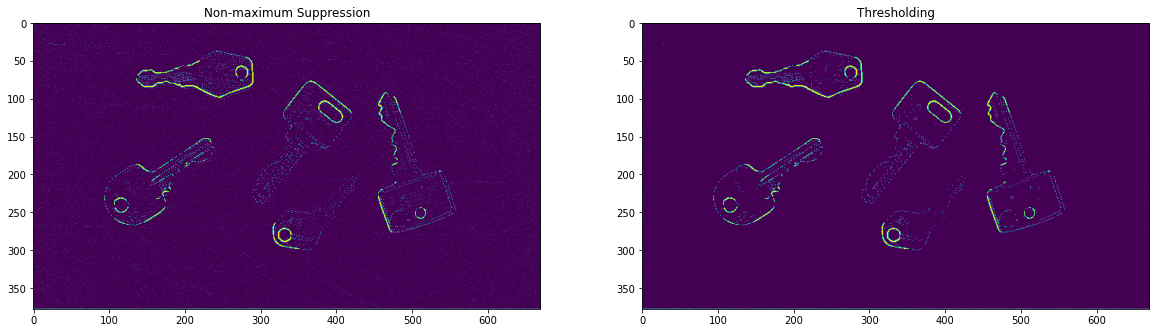

In [ ]:
# ------------ To do ------------- #
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Non-maximum Suppression")
plt.imshow(After_non_maximum_supression)

plt.subplot(1,2,2)
plt.title("Thresholding")
plt.imshow(thresholding)

plt.show()

## Step 5. Hysteresis

In [ ]:
def Connect(img,weak=60):
  # ------------ To do ------------- #
  newImg = img.copy()
  c,r= img.shape
  for i in range(c-1):
    for j in range(r-1):
      if img[i,j]>weak:
        newImg[i,j]=255
      else:
        isEdge=False
        for dj in range(-1,2):
          for di in range(-1,2):
            if(img[i+di][j+dj]>weak):
              isEdge=True
        if(isEdge==True):
          newImg[i][j]=255
  return newImg

dst_img = Connect(thresholding)


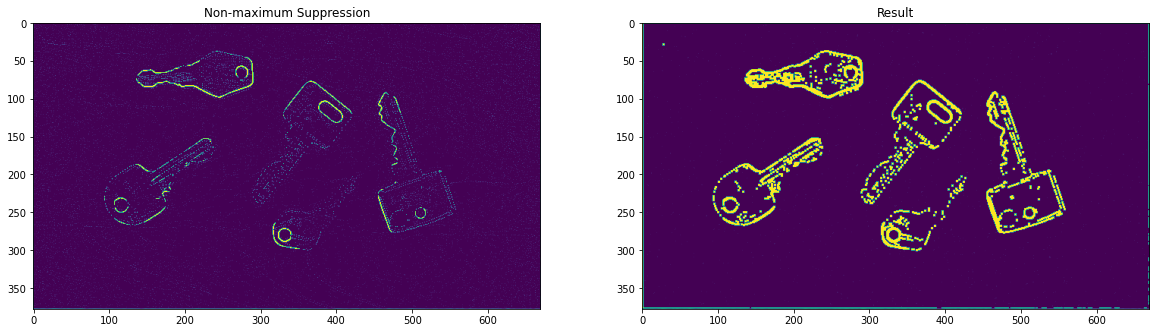

In [ ]:
# ------------ To do ------------- #
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Non-maximum Suppression")
plt.imshow(After_non_maximum_supression)

plt.subplot(1,2,2)
plt.title("Result")
plt.imshow(dst_img)

plt.show()

# Canny Edge OpenCV 套件


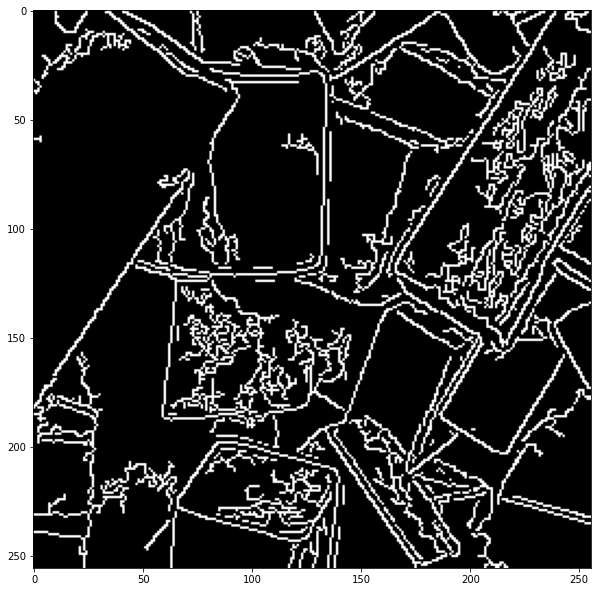

In [ ]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("blocks.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

# 加分討論：為什麼和套件不一樣？

因為cv2提供的參數/預設參數和我們自己設的參數不同，所以會造成出來的解果不同